<a href="https://colab.research.google.com/github/PebbleBuilds/acc-class/blob/experiments/Acc_Class_Data_3Classes_Raw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# APS360 Project: Speech Accent Classifier Project

**Members**: 
Catherine Glossop, Julia Chae, Mingshi Chi, Rocco Ruan 



## Set Up

In [ ]:
# package imports 

import numpy as np
import time
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data.sampler import SubsetRandomSampler
import torchvision.transforms as transforms
import matplotlib.pyplot as plt 
import librosa
import librosa.display


In [ ]:
# mounting the Google Drive 

from google.colab import drive
drive.mount('/content/drive', force_remount = True)

Mounted at /content/drive


In [ ]:
# dataloading utils  

# can load in data from image-conveted dataset 
def generate_data_image():
  data_transform = transforms.Compose([transforms.ToTensor(), transforms.Resize(224)])
  train_data = torchvision.datasets.ImageFolder(root='/content/drive/My Drive/APS360 Group Project/data_testing/data_testing/raw_5s_3classes/train', transform=data_transform)
  test_data = [] #test_data = torchvision.datasets.ImageFolder(root='/content/drive/My Drive/Librosa_MFCC_Test_Class/test', transform=data_transform)
  val_data = torchvision.datasets.ImageFolder(root='/content/drive/My Drive/APS360 Group Project/data_testing/data_testing/raw_5s_3classes/validation', transform=data_transform)

  return train_data, val_data, test_data

def visualize_image_data(dataset):
  batch = 27
  num_workers = 1

  data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch, num_workers=num_workers, shuffle=True)

  # Visualize some sample data
  classes = ['english', 'mandarin', 'hindi', 'tagalog']

  # obtain one batch of training images
  dataiter = iter(data_loader)
  images, labels = dataiter.next()
  images = images.numpy() # convert images to numpy for display
  print(images.shape)
  # plot the images in the batch, along with the corresponding labels
  fig = plt.figure(figsize=(25, 4))
  for idx in np.arange(20):
      ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
      plt.imshow(np.transpose(images[idx], (1, 2, 0)))
      ax.set_title(classes[labels[idx]])

# can also load in data as numpy arrays directly 
def numpy_loader(input):
    item = np.load(input)
    return item

def generate_data_numpy():
  data_transform = transforms.Compose([transforms.ToTensor()])
  data = torchvision.datasets.DatasetFolder(root='/content/drive/My Drive/APS360 Group Project/data_mfcc_npy', loader=numpy_loader,extensions='.npy',transform=data_transform)
  return data

def visualize_numpy_data(dataset):
    batch = 27
    num_workers = 1

    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch, num_workers=num_workers, shuffle=True)

    # Visualize some sample data
    classes = ['english', 'mandarin', 'hindi', 'tagalog']

    # obtain one batch of training images
    dataiter = iter(data_loader)
    array, labels = dataiter.next()
    array = array.numpy() # convert images to numpy for display
    plt.figure()
    librosa.display.specshow(array[0].reshape(128,128))
    plt.colorbar()


In [ ]:
# train utils 

def get_accuracy(model, data_loader):
    correct = 0
    total = 0
    for imgs, labels in data_loader:
        if torch.cuda.is_available():
          imgs = imgs.cuda()
          labels = labels.cuda()
        out = model(imgs) 
        pred = out.max(1, keepdim=True)[1]
        correct += pred.eq(labels.view_as(pred)).sum().item()
        total += imgs.shape[0]
    return correct / total

def get_model_name(name, batch_size, learning_rate, epoch):
    path = "model_{0}_bs{1}_lr{2}_epoch{3}".format(name,
                                                   batch_size,
                                                   learning_rate,
                                                   epoch)
    return path

def plot_graphs(iters, train_loss, val_loss, train_acc, val_acc):
    plt.title("Training Curve")
    plt.plot(iters, train_loss, label="Train")
    #plt.plot (iters, val_loss, label = "Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Loss")
    plt.show()
    plt.title("Training Curve")
    plt.plot(iters, train_acc, label="Train")
    plt.plot(iters, val_acc, label="Validation")
    plt.xlabel("Iterations")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

## Preparing & Visualizing Dataset

(27, 3, 224, 336)


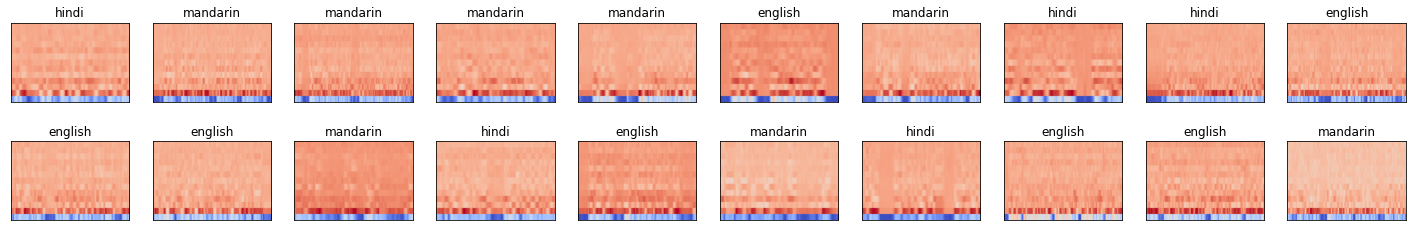

In [ ]:
train_data, val_data, test_data= generate_data_image()
visualize_image_data(train_data)

In [ ]:
from collections import Counter

print(dict(Counter(train_data.targets)))
train_data.classes

{0: 402, 1: 502, 2: 578}


['english', 'india', 'mandarin']

## Accent Classifier Architecture


## Training 

In [ ]:
def train_net(net, batch_size=8, num_workers = 1, learning_rate=0.005, num_epochs=30):
    torch.manual_seed(5)
    # Train a classifier on sign language images
    # Fixed PyTorch random seed for reproducible result
    
    # Obtain the PyTorch data loader objects to load batches of the datasets
    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_data, batch_size=batch_size, num_workers=num_workers, shuffle=True)

    # The loss function will be Cross Entropy and Optimizer will be SGD with Momentum.
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9)

    iters, losses, train_acc, val_acc = [], [], [], []

    # training
    n = 0 # the number of iterations
    start_time=time.time()
    for epoch in range(num_epochs):
        mini_b=0
        mini_batch_correct = 0
        mini_batch_total = 0
        epoch_correct = 0
        epoch_total = 0
        for imgs, labels in train_loader:
            # Get the inputs
            if torch.cuda.is_available():
              imgs = imgs.cuda()
              labels = labels.cuda()
              net = net.cuda()

            # Forward pass, backward pass, and optimize
            out = net(imgs)             # forward pass
            loss = criterion(out, labels) # compute the total loss
            loss.backward()               # backward pass (compute parameter updates)
            optimizer.step()              # make the updates for each parameter
            optimizer.zero_grad()         # a clean up step for PyTorch

            # Mini_batch Accuracy
            pred = out.max(1, keepdim=True)[1]
            mini_batch_correct = pred.eq(labels.view_as(pred)).sum().item()
            mini_batch_total = imgs.shape[0]
            mini_batch_acc = mini_batch_correct / mini_batch_total
            train_acc.append(mini_batch_acc)

            # Saving epoch accuracy
            epoch_correct += mini_batch_correct 
            epoch_total += mini_batch_total 

            # save the current training information
            iters.append(n)
            losses.append(float(loss)/batch_size)             # compute *average* loss
            val_acc.append(get_accuracy(net, val_loader))  # compute validation accuracy
            n += 1
            mini_b += 1

        print("Epoch: ",epoch,"Train Accuracy: ",epoch_correct/epoch_total,'Val Accuracy: ', val_acc[-1],'Progress: % 6.2f ' % ((epoch * len(train_loader) + mini_b) / (num_epochs * len(train_loader))*100),'%', "Time Elapsed: % 6.2f s " % (time.time()-start_time))
        print ("Epoch %d Finished. " % epoch ,"Time per Epoch: % 6.2f s "% ((time.time()-start_time) / (epoch +1)))
        if (epoch>0 and (epoch+1)%25==0):
          model_path = get_model_name(net.name, batch_size, learning_rate, epoch + 1)
          torch.save(net.state_dict(), model_path)
          plot_graphs(iters, losses, [], train_acc, val_acc)
    
    plot_graphs(iters, losses, [], train_acc, val_acc)
    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print ("Total time:  % 6.2f s  Time per Epoch: % 6.2f s " % ( elapsed_time, (elapsed_time / num_epochs) ))
    

## Baseline Experimentation with 3 classes, image size 224

## Increasing Hidden Units in fc, image size 224

In [ ]:
class AccentClassifier(nn.Module):
    def __init__(self):
          super(AccentClassifier, self).__init__()
          self.name = 'AccentClasifier_3.3'
          self.conv1 = nn.Conv2d(3, 32, 3) #in_channels, out_chanels, kernel_size
          self.pool = nn.MaxPool2d(2, 2) #kernel_size, stride 
          self.conv2 = nn.Conv2d(32, 64, 3) #in_channels, out_chanels, kernel_size
          self.fc1 = nn.Linear(64*54*82, 512)
          self.fc2 = nn.Linear(512, 3)

    def forward(self, x):
          x = self.pool(F.relu(self.conv1(x)))
          x = self.pool(F.relu(self.conv2(x)))
          x = x.view(-1, 64*54*82)
          x = F.relu(self.fc1(x))
          x = self.fc2(x)
          return x

Using CUDA
Epoch:  0 Train Accuracy:  0.37314439946018896 Val Accuracy:  0.3557312252964427 Progress:   1.00  % Time Elapsed:  364.67 s 
Epoch 0 Finished.  Time per Epoch:  364.67 s 
Epoch:  1 Train Accuracy:  0.398110661268556 Val Accuracy:  0.2490118577075099 Progress:   2.00  % Time Elapsed:  470.00 s 
Epoch 1 Finished.  Time per Epoch:  235.00 s 
Epoch:  2 Train Accuracy:  0.3765182186234818 Val Accuracy:  0.3557312252964427 Progress:   3.00  % Time Elapsed:  575.68 s 
Epoch 2 Finished.  Time per Epoch:  191.89 s 
Epoch:  3 Train Accuracy:  0.3900134952766532 Val Accuracy:  0.3557312252964427 Progress:   4.00  % Time Elapsed:  682.04 s 
Epoch 3 Finished.  Time per Epoch:  170.51 s 
Epoch:  4 Train Accuracy:  0.3900134952766532 Val Accuracy:  0.3557312252964427 Progress:   5.00  % Time Elapsed:  789.08 s 
Epoch 4 Finished.  Time per Epoch:  157.82 s 
Epoch:  5 Train Accuracy:  0.3900134952766532 Val Accuracy:  0.3557312252964427 Progress:   6.00  % Time Elapsed:  898.14 s 
Epoch 5 F

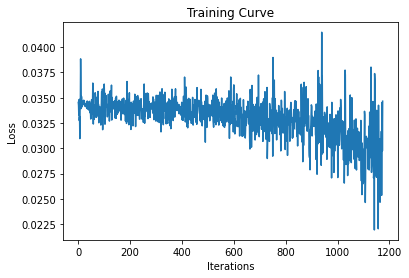

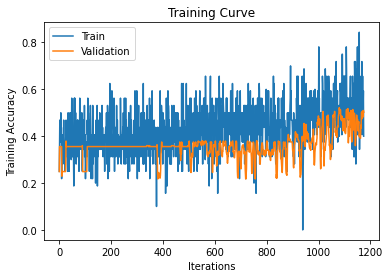

Epoch:  25 Train Accuracy:  0.5856950067476383 Val Accuracy:  0.4743083003952569 Progress:  26.00  % Time Elapsed:  2922.53 s 
Epoch 25 Finished.  Time per Epoch:  112.40 s 
Epoch:  26 Train Accuracy:  0.5863697705802969 Val Accuracy:  0.47035573122529645 Progress:  27.00  % Time Elapsed:  3018.64 s 
Epoch 26 Finished.  Time per Epoch:  111.80 s 
Epoch:  27 Train Accuracy:  0.6376518218623481 Val Accuracy:  0.5533596837944664 Progress:  28.00  % Time Elapsed:  3115.70 s 
Epoch 27 Finished.  Time per Epoch:  111.28 s 
Epoch:  28 Train Accuracy:  0.6497975708502024 Val Accuracy:  0.48616600790513836 Progress:  29.00  % Time Elapsed:  3212.05 s 
Epoch 28 Finished.  Time per Epoch:  110.76 s 
Epoch:  29 Train Accuracy:  0.645748987854251 Val Accuracy:  0.4782608695652174 Progress:  30.00  % Time Elapsed:  3308.34 s 
Epoch 29 Finished.  Time per Epoch:  110.28 s 
Epoch:  30 Train Accuracy:  0.659919028340081 Val Accuracy:  0.43873517786561267 Progress:  31.00  % Time Elapsed:  3405.50 s 
Ep

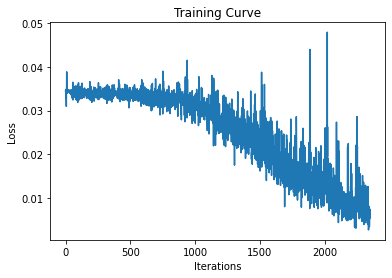

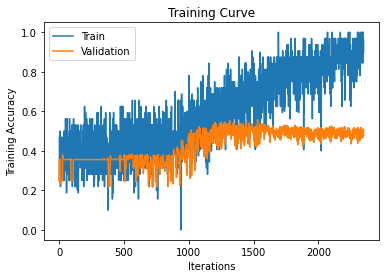

Epoch:  50 Train Accuracy:  0.8717948717948718 Val Accuracy:  0.5177865612648221 Progress:  51.00  % Time Elapsed:  5342.77 s 
Epoch 50 Finished.  Time per Epoch:  104.76 s 
Epoch:  51 Train Accuracy:  0.8940620782726046 Val Accuracy:  0.5019762845849802 Progress:  52.00  % Time Elapsed:  5438.78 s 
Epoch 51 Finished.  Time per Epoch:  104.59 s 
Epoch:  52 Train Accuracy:  0.9527665317139001 Val Accuracy:  0.5059288537549407 Progress:  53.00  % Time Elapsed:  5535.80 s 
Epoch 52 Finished.  Time per Epoch:  104.45 s 
Epoch:  53 Train Accuracy:  0.9527665317139001 Val Accuracy:  0.5019762845849802 Progress:  54.00  % Time Elapsed:  5631.92 s 
Epoch 53 Finished.  Time per Epoch:  104.29 s 
Epoch:  54 Train Accuracy:  0.941970310391363 Val Accuracy:  0.49407114624505927 Progress:  55.00  % Time Elapsed:  5728.32 s 
Epoch 54 Finished.  Time per Epoch:  104.15 s 
Epoch:  55 Train Accuracy:  0.9251012145748988 Val Accuracy:  0.4624505928853755 Progress:  56.00  % Time Elapsed:  5824.70 s 
Epo

KeyboardInterrupt: ignored

In [ ]:
if torch.cuda.is_available():
  print("Using CUDA")
batch_size = 32
num_epochs = 100
learning_rate = 0.001
acc_net = AccentClassifier()
train_net(acc_net, batch_size=batch_size, learning_rate = learning_rate, num_epochs = num_epochs)

In [ ]:
# dataloading utils  

# can load in data from image-conveted dataset 
def generate_data_image():
  data_transform = transforms.Compose([transforms.ToTensor(), transforms.Resize(224)])
  train_data = torchvision.datasets.ImageFolder(root='/content/drive/My Drive/APS360 Group Project/data_testing/data_testing/raw_10s_3classes/train', transform=data_transform)
  test_data = [] #test_data = torchvision.datasets.ImageFolder(root='/content/drive/My Drive/Librosa_MFCC_Test_Class/test', transform=data_transform)
  val_data = torchvision.datasets.ImageFolder(root='/content/drive/My Drive/APS360 Group Project/data_testing/data_testing/raw_10s_3classes/validation', transform=data_transform)

  return train_data, val_data, test_data

def visualize_image_data(dataset):
  batch = 27
  num_workers = 1

  data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch, num_workers=num_workers, shuffle=True)

  # Visualize some sample data
  classes = ['english', 'mandarin', 'hindi', 'tagalog']

  # obtain one batch of training images
  dataiter = iter(data_loader)
  images, labels = dataiter.next()
  images = images.numpy() # convert images to numpy for display
  print(images.shape)
  # plot the images in the batch, along with the corresponding labels
  fig = plt.figure(figsize=(25, 4))
  for idx in np.arange(20):
      ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
      plt.imshow(np.transpose(images[idx], (1, 2, 0)))
      ax.set_title(classes[labels[idx]])

# can also load in data as numpy arrays directly 
def numpy_loader(input):
    item = np.load(input)
    return item

def generate_data_numpy():
  data_transform = transforms.Compose([transforms.ToTensor()])
  data = torchvision.datasets.DatasetFolder(root='/content/drive/My Drive/APS360 Group Project/data_mfcc_npy', loader=numpy_loader,extensions='.npy',transform=data_transform)
  return data

def visualize_numpy_data(dataset):
    batch = 27
    num_workers = 1

    data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch, num_workers=num_workers, shuffle=True)

    # Visualize some sample data
    classes = ['english', 'mandarin', 'hindi', 'tagalog']

    # obtain one batch of training images
    dataiter = iter(data_loader)
    array, labels = dataiter.next()
    array = array.numpy() # convert images to numpy for display
    plt.figure()
    librosa.display.specshow(array[0].reshape(128,128))
    plt.colorbar()


(27, 3, 224, 336)


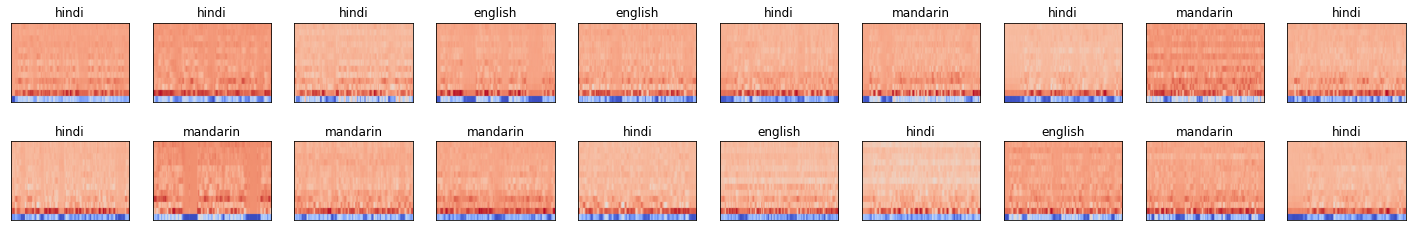

In [ ]:
train_data, val_data, test_data= generate_data_image()
visualize_image_data(train_data)

In [ ]:
from collections import Counter

print(dict(Counter(train_data.targets)))
train_data.classes

{0: 126, 1: 162, 2: 184}


['english', 'india', 'mandarin']

Using CUDA
Epoch:  0 Train Accuracy:  0.3411016949152542 Val Accuracy:  0.3670886075949367 Progress:   1.00  % Time Elapsed:  97.60 s 
Epoch 0 Finished.  Time per Epoch:  97.60 s 
Epoch:  1 Train Accuracy:  0.3728813559322034 Val Accuracy:  0.3670886075949367 Progress:   2.00  % Time Elapsed:  111.55 s 
Epoch 1 Finished.  Time per Epoch:  55.77 s 
Epoch:  2 Train Accuracy:  0.3792372881355932 Val Accuracy:  0.3670886075949367 Progress:   3.00  % Time Elapsed:  125.51 s 
Epoch 2 Finished.  Time per Epoch:  41.84 s 
Epoch:  3 Train Accuracy:  0.3919491525423729 Val Accuracy:  0.34177215189873417 Progress:   4.00  % Time Elapsed:  139.38 s 
Epoch 3 Finished.  Time per Epoch:  34.85 s 
Epoch:  4 Train Accuracy:  0.4491525423728814 Val Accuracy:  0.3670886075949367 Progress:   5.00  % Time Elapsed:  153.11 s 
Epoch 4 Finished.  Time per Epoch:  30.62 s 
Epoch:  5 Train Accuracy:  0.4088983050847458 Val Accuracy:  0.3670886075949367 Progress:   6.00  % Time Elapsed:  166.71 s 
Epoch 5 Finish

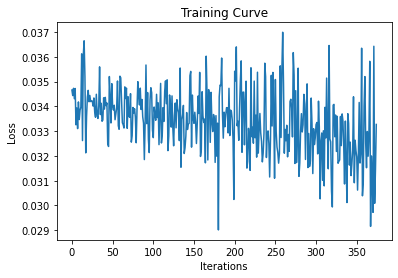

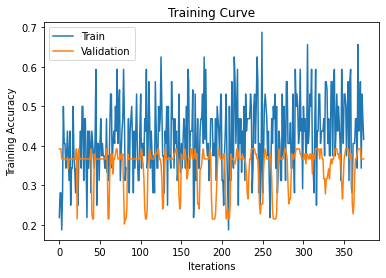

Epoch:  25 Train Accuracy:  0.4576271186440678 Val Accuracy:  0.3670886075949367 Progress:  26.00  % Time Elapsed:  436.64 s 
Epoch 25 Finished.  Time per Epoch:  16.79 s 
Epoch:  26 Train Accuracy:  0.451271186440678 Val Accuracy:  0.3924050632911392 Progress:  27.00  % Time Elapsed:  449.48 s 
Epoch 26 Finished.  Time per Epoch:  16.65 s 
Epoch:  27 Train Accuracy:  0.4682203389830508 Val Accuracy:  0.31645569620253167 Progress:  28.00  % Time Elapsed:  462.31 s 
Epoch 27 Finished.  Time per Epoch:  16.51 s 
Epoch:  28 Train Accuracy:  0.4682203389830508 Val Accuracy:  0.27848101265822783 Progress:  29.00  % Time Elapsed:  475.15 s 
Epoch 28 Finished.  Time per Epoch:  16.38 s 
Epoch:  29 Train Accuracy:  0.4385593220338983 Val Accuracy:  0.35443037974683544 Progress:  30.00  % Time Elapsed:  488.13 s 
Epoch 29 Finished.  Time per Epoch:  16.27 s 
Epoch:  30 Train Accuracy:  0.4936440677966102 Val Accuracy:  0.35443037974683544 Progress:  31.00  % Time Elapsed:  501.03 s 
Epoch 30 Fi

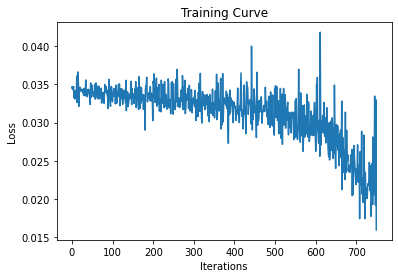

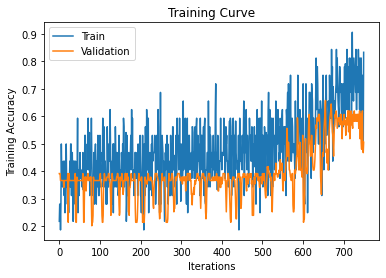

Epoch:  50 Train Accuracy:  0.6398305084745762 Val Accuracy:  0.5316455696202531 Progress:  51.00  % Time Elapsed:  756.48 s 
Epoch 50 Finished.  Time per Epoch:  14.83 s 
Epoch:  51 Train Accuracy:  0.7436440677966102 Val Accuracy:  0.6075949367088608 Progress:  52.00  % Time Elapsed:  769.00 s 
Epoch 51 Finished.  Time per Epoch:  14.79 s 
Epoch:  52 Train Accuracy:  0.7690677966101694 Val Accuracy:  0.5063291139240507 Progress:  53.00  % Time Elapsed:  781.44 s 
Epoch 52 Finished.  Time per Epoch:  14.74 s 
Epoch:  53 Train Accuracy:  0.7584745762711864 Val Accuracy:  0.5316455696202531 Progress:  54.00  % Time Elapsed:  794.05 s 
Epoch 53 Finished.  Time per Epoch:  14.70 s 
Epoch:  54 Train Accuracy:  0.798728813559322 Val Accuracy:  0.569620253164557 Progress:  55.00  % Time Elapsed:  806.56 s 
Epoch 54 Finished.  Time per Epoch:  14.66 s 
Epoch:  55 Train Accuracy:  0.826271186440678 Val Accuracy:  0.5949367088607594 Progress:  56.00  % Time Elapsed:  819.15 s 
Epoch 55 Finished

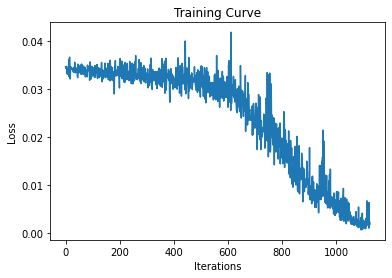

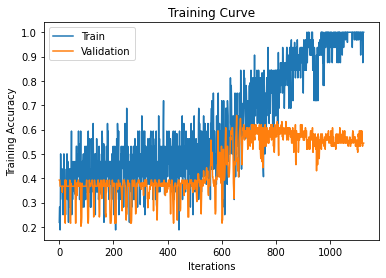

Epoch:  75 Train Accuracy:  0.9915254237288136 Val Accuracy:  0.5822784810126582 Progress:  76.00  % Time Elapsed:  1072.70 s 
Epoch 75 Finished.  Time per Epoch:  14.11 s 
Epoch:  76 Train Accuracy:  0.9978813559322034 Val Accuracy:  0.5569620253164557 Progress:  77.00  % Time Elapsed:  1085.14 s 
Epoch 76 Finished.  Time per Epoch:  14.09 s 
Epoch:  77 Train Accuracy:  0.9978813559322034 Val Accuracy:  0.5316455696202531 Progress:  78.00  % Time Elapsed:  1097.75 s 
Epoch 77 Finished.  Time per Epoch:  14.07 s 
Epoch:  78 Train Accuracy:  0.9978813559322034 Val Accuracy:  0.5569620253164557 Progress:  79.00  % Time Elapsed:  1110.17 s 
Epoch 78 Finished.  Time per Epoch:  14.05 s 
Epoch:  79 Train Accuracy:  0.9745762711864406 Val Accuracy:  0.5569620253164557 Progress:  80.00  % Time Elapsed:  1122.53 s 
Epoch 79 Finished.  Time per Epoch:  14.03 s 
Epoch:  80 Train Accuracy:  0.9936440677966102 Val Accuracy:  0.5443037974683544 Progress:  81.00  % Time Elapsed:  1135.03 s 
Epoch 80

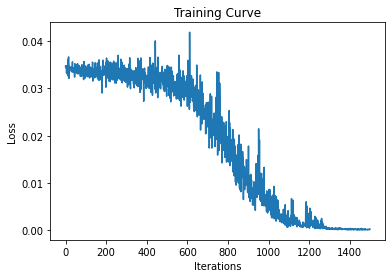

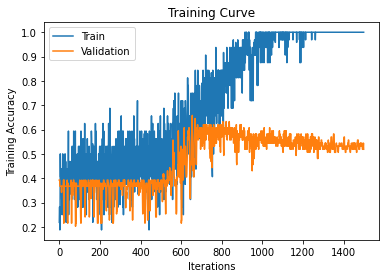

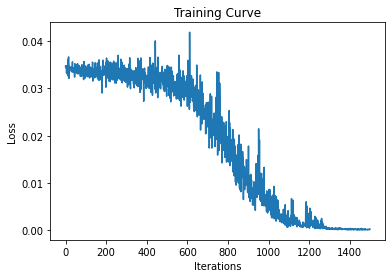

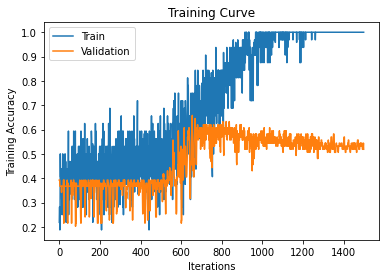

Finished Training
Total time:   1378.49 s  Time per Epoch:  13.78 s 


In [ ]:
if torch.cuda.is_available():
  print("Using CUDA")
batch_size = 32
num_epochs = 100
learning_rate = 0.001
acc_net = AccentClassifier()
train_net(acc_net, batch_size=batch_size, learning_rate = learning_rate, num_epochs = num_epochs)

In [ ]:
class AccentClassifier(nn.Module):
    def __init__(self):
          super(AccentClassifier, self).__init__()
          self.name = 'AccentClasifier_3.4'
          self.conv1 = nn.Conv2d(3, 32, 3) #in_channels, out_chanels, kernel_size
          self.pool = nn.MaxPool2d(2, 2) #kernel_size, stride 
          self.conv2 = nn.Conv2d(32, 64, 3) #in_channels, out_chanels, kernel_size
          self.fc1 = nn.Linear(64*54*82, 128)
          self.fc2 = nn.Linear(128, 3)

    def forward(self, x):
          x = self.pool(F.relu(self.conv1(x)))
          x = self.pool(F.relu(self.conv2(x)))
          x = x.view(-1, 64*54*82)
          x = F.relu(self.fc1(x))
          x = self.fc2(x)
          return x

Using CUDA
Epoch:  0 Train Accuracy:  0.3665254237288136 Val Accuracy:  0.3670886075949367 Progress:   1.00  % Time Elapsed:  15.47 s 
Epoch 0 Finished.  Time per Epoch:  15.47 s 
Epoch:  1 Train Accuracy:  0.3813559322033898 Val Accuracy:  0.3670886075949367 Progress:   2.00  % Time Elapsed:  31.04 s 
Epoch 1 Finished.  Time per Epoch:  15.52 s 
Epoch:  2 Train Accuracy:  0.3940677966101695 Val Accuracy:  0.379746835443038 Progress:   3.00  % Time Elapsed:  46.54 s 
Epoch 2 Finished.  Time per Epoch:  15.51 s 
Epoch:  3 Train Accuracy:  0.3898305084745763 Val Accuracy:  0.3670886075949367 Progress:   4.00  % Time Elapsed:  61.85 s 
Epoch 3 Finished.  Time per Epoch:  15.46 s 
Epoch:  4 Train Accuracy:  0.4406779661016949 Val Accuracy:  0.379746835443038 Progress:   5.00  % Time Elapsed:  77.30 s 
Epoch 4 Finished.  Time per Epoch:  15.46 s 
Epoch:  5 Train Accuracy:  0.4449152542372881 Val Accuracy:  0.3670886075949367 Progress:   6.00  % Time Elapsed:  92.54 s 
Epoch 5 Finished.  Tim

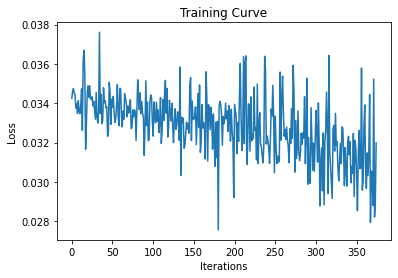

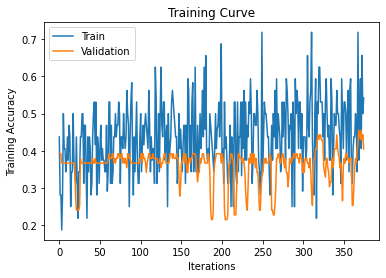

Epoch:  25 Train Accuracy:  0.5042372881355932 Val Accuracy:  0.5063291139240507 Progress:  26.00  % Time Elapsed:  402.07 s 
Epoch 25 Finished.  Time per Epoch:  15.46 s 
Epoch:  26 Train Accuracy:  0.5296610169491526 Val Accuracy:  0.46835443037974683 Progress:  27.00  % Time Elapsed:  419.88 s 
Epoch 26 Finished.  Time per Epoch:  15.55 s 
Epoch:  27 Train Accuracy:  0.5423728813559322 Val Accuracy:  0.46835443037974683 Progress:  28.00  % Time Elapsed:  437.82 s 
Epoch 27 Finished.  Time per Epoch:  15.64 s 
Epoch:  28 Train Accuracy:  0.5635593220338984 Val Accuracy:  0.5822784810126582 Progress:  29.00  % Time Elapsed:  455.82 s 
Epoch 28 Finished.  Time per Epoch:  15.72 s 
Epoch:  29 Train Accuracy:  0.565677966101695 Val Accuracy:  0.379746835443038 Progress:  30.00  % Time Elapsed:  474.01 s 
Epoch 29 Finished.  Time per Epoch:  15.80 s 
Epoch:  30 Train Accuracy:  0.5508474576271186 Val Accuracy:  0.35443037974683544 Progress:  31.00  % Time Elapsed:  492.13 s 
Epoch 30 Fini

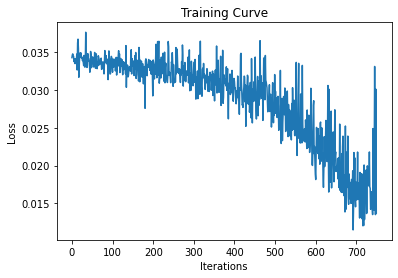

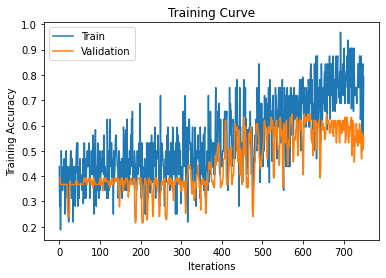

Epoch:  50 Train Accuracy:  0.7457627118644068 Val Accuracy:  0.5443037974683544 Progress:  51.00  % Time Elapsed:  848.78 s 
Epoch 50 Finished.  Time per Epoch:  16.64 s 
Epoch:  51 Train Accuracy:  0.836864406779661 Val Accuracy:  0.5949367088607594 Progress:  52.00  % Time Elapsed:  867.07 s 
Epoch 51 Finished.  Time per Epoch:  16.67 s 
Epoch:  52 Train Accuracy:  0.8538135593220338 Val Accuracy:  0.569620253164557 Progress:  53.00  % Time Elapsed:  886.16 s 
Epoch 52 Finished.  Time per Epoch:  16.72 s 
Epoch:  53 Train Accuracy:  0.902542372881356 Val Accuracy:  0.5569620253164557 Progress:  54.00  % Time Elapsed:  904.56 s 
Epoch 53 Finished.  Time per Epoch:  16.75 s 
Epoch:  54 Train Accuracy:  0.8983050847457628 Val Accuracy:  0.5822784810126582 Progress:  55.00  % Time Elapsed:  922.98 s 
Epoch 54 Finished.  Time per Epoch:  16.78 s 
Epoch:  55 Train Accuracy:  0.9216101694915254 Val Accuracy:  0.5822784810126582 Progress:  56.00  % Time Elapsed:  941.68 s 
Epoch 55 Finished

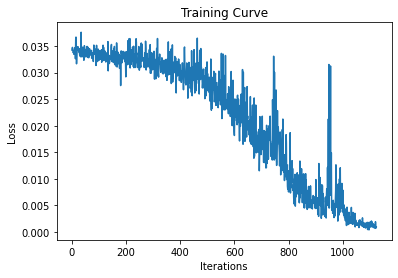

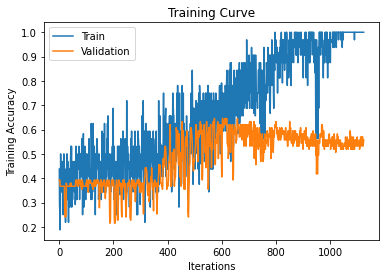

Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f12d72f5a90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f12d72f5a90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel

Epoch:  75 Train Accuracy:  1.0 Val Accuracy:  0.569620253164557 Progress:  76.00  % Time Elapsed:  1321.11 s 
Epoch 75 Finished.  Time per Epoch:  17.38 s 


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f12d72f5a90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f12d72f5a90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel

Epoch:  76 Train Accuracy:  1.0 Val Accuracy:  0.5189873417721519 Progress:  77.00  % Time Elapsed:  1342.98 s 
Epoch 76 Finished.  Time per Epoch:  17.44 s 


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f12d72f5a90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f12d72f5a90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel

Epoch:  77 Train Accuracy:  1.0 Val Accuracy:  0.5443037974683544 Progress:  78.00  % Time Elapsed:  1365.00 s 
Epoch 77 Finished.  Time per Epoch:  17.50 s 


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f12d72f5a90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f12d72f5a90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel

Epoch:  78 Train Accuracy:  1.0 Val Accuracy:  0.5822784810126582 Progress:  79.00  % Time Elapsed:  1387.11 s 
Epoch 78 Finished.  Time per Epoch:  17.56 s 


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f12d72f5a90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f12d72f5a90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel

Epoch:  79 Train Accuracy:  0.9915254237288136 Val Accuracy:  0.5316455696202531 Progress:  80.00  % Time Elapsed:  1409.30 s 
Epoch 79 Finished.  Time per Epoch:  17.62 s 


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f12d72f5a90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f12d72f5a90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel

Epoch:  80 Train Accuracy:  0.9978813559322034 Val Accuracy:  0.5569620253164557 Progress:  81.00  % Time Elapsed:  1431.49 s 
Epoch 80 Finished.  Time per Epoch:  17.67 s 


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f12d72f5a90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f12d72f5a90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel

Epoch:  81 Train Accuracy:  1.0 Val Accuracy:  0.569620253164557 Progress:  82.00  % Time Elapsed:  1453.74 s 
Epoch 81 Finished.  Time per Epoch:  17.73 s 


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f12d72f5a90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f12d72f5a90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel

Epoch:  82 Train Accuracy:  1.0 Val Accuracy:  0.5189873417721519 Progress:  83.00  % Time Elapsed:  1475.42 s 
Epoch 82 Finished.  Time per Epoch:  17.78 s 


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f12d72f5a90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f12d72f5a90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel

Epoch:  83 Train Accuracy:  1.0 Val Accuracy:  0.5189873417721519 Progress:  84.00  % Time Elapsed:  1498.02 s 
Epoch 83 Finished.  Time per Epoch:  17.83 s 


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f12d72f5a90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f12d72f5a90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel

Epoch:  84 Train Accuracy:  1.0 Val Accuracy:  0.5189873417721519 Progress:  85.00  % Time Elapsed:  1520.39 s 
Epoch 84 Finished.  Time per Epoch:  17.89 s 


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f12d72f5a90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f12d72f5a90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel

Epoch:  85 Train Accuracy:  1.0 Val Accuracy:  0.5189873417721519 Progress:  86.00  % Time Elapsed:  1542.55 s 
Epoch 85 Finished.  Time per Epoch:  17.94 s 


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f12d72f5a90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f12d72f5a90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel

Epoch:  86 Train Accuracy:  1.0 Val Accuracy:  0.5189873417721519 Progress:  87.00  % Time Elapsed:  1564.64 s 
Epoch 86 Finished.  Time per Epoch:  17.98 s 


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f12d72f5a90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f12d72f5a90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel

Epoch:  87 Train Accuracy:  1.0 Val Accuracy:  0.5316455696202531 Progress:  88.00  % Time Elapsed:  1586.87 s 
Epoch 87 Finished.  Time per Epoch:  18.03 s 


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f12d72f5a90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f12d72f5a90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel

Epoch:  88 Train Accuracy:  1.0 Val Accuracy:  0.5316455696202531 Progress:  89.00  % Time Elapsed:  1609.15 s 
Epoch 88 Finished.  Time per Epoch:  18.08 s 


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f12d72f5a90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f12d72f5a90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel

Epoch:  89 Train Accuracy:  1.0 Val Accuracy:  0.5063291139240507 Progress:  90.00  % Time Elapsed:  1631.40 s 
Epoch 89 Finished.  Time per Epoch:  18.13 s 


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f12d72f5a90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f12d72f5a90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel

Epoch:  90 Train Accuracy:  1.0 Val Accuracy:  0.5189873417721519 Progress:  91.00  % Time Elapsed:  1653.68 s 
Epoch 90 Finished.  Time per Epoch:  18.17 s 


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f12d72f5a90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f12d72f5a90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel

Epoch:  91 Train Accuracy:  1.0 Val Accuracy:  0.5316455696202531 Progress:  92.00  % Time Elapsed:  1676.08 s 
Epoch 91 Finished.  Time per Epoch:  18.22 s 


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f12d72f5a90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f12d72f5a90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel

Epoch:  92 Train Accuracy:  1.0 Val Accuracy:  0.5189873417721519 Progress:  93.00  % Time Elapsed:  1698.66 s 
Epoch 92 Finished.  Time per Epoch:  18.27 s 


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f12d72f5a90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f12d72f5a90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel

Epoch:  93 Train Accuracy:  1.0 Val Accuracy:  0.5063291139240507 Progress:  94.00  % Time Elapsed:  1721.09 s 
Epoch 93 Finished.  Time per Epoch:  18.31 s 


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f12d72f5a90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f12d72f5a90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel

Epoch:  94 Train Accuracy:  1.0 Val Accuracy:  0.5443037974683544 Progress:  95.00  % Time Elapsed:  1743.63 s 
Epoch 94 Finished.  Time per Epoch:  18.35 s 


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f12d72f5a90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f12d72f5a90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel

Epoch:  95 Train Accuracy:  1.0 Val Accuracy:  0.5189873417721519 Progress:  96.00  % Time Elapsed:  1766.13 s 
Epoch 95 Finished.  Time per Epoch:  18.40 s 


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f12d72f5a90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f12d72f5a90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel

Epoch:  96 Train Accuracy:  1.0 Val Accuracy:  0.5063291139240507 Progress:  97.00  % Time Elapsed:  1788.27 s 
Epoch 96 Finished.  Time per Epoch:  18.44 s 


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f12d72f5a90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f12d72f5a90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel

Epoch:  97 Train Accuracy:  1.0 Val Accuracy:  0.5316455696202531 Progress:  98.00  % Time Elapsed:  1810.53 s 
Epoch 97 Finished.  Time per Epoch:  18.47 s 


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f12d72f5a90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f12d72f5a90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel

Epoch:  98 Train Accuracy:  1.0 Val Accuracy:  0.5063291139240507 Progress:  99.00  % Time Elapsed:  1832.06 s 
Epoch 98 Finished.  Time per Epoch:  18.51 s 


Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f12d72f5a90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1177, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/usr/lib/python3.6/multiprocessing/process.py", line 122, in join
    assert self._parent_pid == os.getpid(), 'can only join a child process'
AssertionError: can only join a child process
Exception ignored in: <bound method _MultiProcessingDataLoaderIter.__del__ of <torch.utils.data.dataloader._MultiProcessingDataLoaderIter object at 0x7f12d72f5a90>>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 1203, in __del__
    sel

Epoch:  99 Train Accuracy:  1.0 Val Accuracy:  0.5189873417721519 Progress:  100.00  % Time Elapsed:  1853.44 s 
Epoch 99 Finished.  Time per Epoch:  18.53 s 


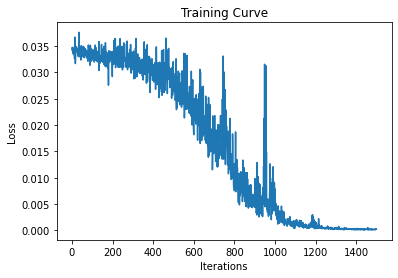

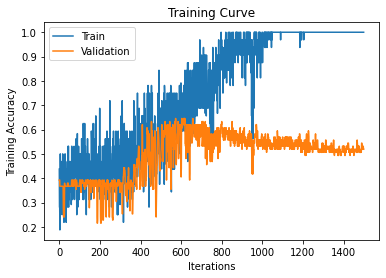

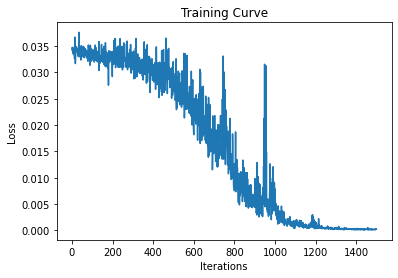

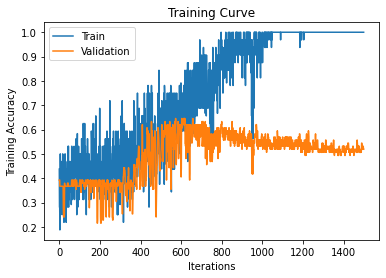

Finished Training
Total time:   1854.66 s  Time per Epoch:  18.55 s 


In [ ]:
if torch.cuda.is_available():
  print("Using CUDA")
batch_size = 32
num_epochs = 100
learning_rate = 0.001
acc_net = AccentClassifier()
train_net(acc_net, batch_size=batch_size, learning_rate = learning_rate, num_epochs = num_epochs)